This notebook gives an example of data pre-treatment of `xArray` datasets. The main purpose of this pre-treatment is computation of some additional variables, not avaliable in the initial data sets and coarsening the data to another grid at lower spatial resolution. More precisely, it contains following functions:
- Selection from a global mesh on a regional one
- Building the staggered grid with or withour metrics with the use of `xgcm` package
- Computation of additional variables. In the present demonstration, variables related to equation of state are computed. Some variables need to be computed before coarsening, and some of them after. It is a common situation in subgrid parametrization studies.
- Coarsening from a high-resolution non-uniform grid to a low-resolution non-uniform grid. Is it done with `xESMF` library, that provides a method adapted for non-uniform grids with masked values and compatible with 'lazy' `Dask` excution.
- Computation with `Dask` and saving on cloud in `.zarr` format for further reuse in the next stages of the workflow.

The intermediate steps are tested with toy high and low-resolution datasets. 

Last part of the notebooks gives a pipeline of data-treatment for data from `eNATL60` simulation. The original (high-res) data is at 1/60 degree resolution. During the treatment, additional variables are computed and the high-res datasets are coarsened to a low-res mesh with 1/4 degree resultion. The low-res mesh corresponds to `eORCA025` simulations. 

# Dask start

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43523")

# Import

In [54]:
import sys
sys.path.insert(1, '..')

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import gcm_filters
from dask import compute
import xgcm
import xesmf as xe
import os
import pandas as pd

In [4]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# Create test datasets

Create a toy dataset for tests with adjusted size and two variables `sosstsst` and `sosaline`. The resolution is given in degrees in variable `spatial_step_degree`

In [5]:
def create_test_dataset(width, height, time_length, spatial_step_degree) :
    # create axes
    x = np.arange(width)
    y = np.arange(height)
    time_counter = pd.date_range("2014-09-06", freq='H', periods=time_length)
    
    vector_lat = y*spatial_step_degree
    vector_lon = x*spatial_step_degree
    lat, lon = np.meshgrid(vector_lat, vector_lon, indexing='ij')
    
    var1 = np.full((height,width,time_length), 20.)
    var2 = np.full((height,width,time_length), 0.)
    mask = np.full((height,width), 1.)
    
    test_ds = xr.Dataset(
         data_vars=dict(
             sosstsst=(["y", "x", "time_counter"], var1),
             sosaline=(["y", "x", "time_counter"], var2),
             tmask=(["y", "x"], mask),
         ),
         coords=dict(
             lon=(["y", "x"], lon),
             lat=(["y", "x"], lat),
             time_counter=time_counter,
         ),
         attrs=dict(description="Test dataset"),
     )
    return test_ds

Create high-resolution test dataset of size 300x200 points with 10 time snapshots and that is assumed to correspond to the resolution of 1/40 degree:

In [7]:
test_ds_HR = create_test_dataset(width = 300, height=200, time_length=10, spatial_step_degree=1./40.)

In [8]:
test_ds_HR

<xarray.Dataset>
Dimensions:       (y: 200, x: 300, time_counter: 10)
Coordinates:
    lon           (y, x) float64 0.0 0.025 0.05 0.075 ... 7.4 7.425 7.45 7.475
    lat           (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 4.975 4.975 4.975 4.975
  * time_counter  (time_counter) datetime64[ns] 2014-09-06 ... 2014-09-06T09:...
Dimensions without coordinates: y, x
Data variables:
    sosstsst      (y, x, time_counter) float64 20.0 20.0 20.0 ... 20.0 20.0 20.0
    sosaline      (y, x, time_counter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tmask         (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    description:  Test dataset

Create low-resolution test dataset of size 60x40 points with 10 time snapshots and that is assumed to correspond to the resolution of 1/4 degree:

In [9]:
test_ds_LR = create_test_dataset(width = 60, height=40, time_length=10, spatial_step_degree=1./4.)

In [10]:
test_ds_LR

<xarray.Dataset>
Dimensions:       (y: 40, x: 60, time_counter: 10)
Coordinates:
    lon           (y, x) float64 0.0 0.25 0.5 0.75 1.0 ... 14.0 14.25 14.5 14.75
    lat           (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 9.75 9.75 9.75 9.75
  * time_counter  (time_counter) datetime64[ns] 2014-09-06 ... 2014-09-06T09:...
Dimensions without coordinates: y, x
Data variables:
    sosstsst      (y, x, time_counter) float64 20.0 20.0 20.0 ... 20.0 20.0 20.0
    sosaline      (y, x, time_counter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tmask         (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    description:  Test dataset

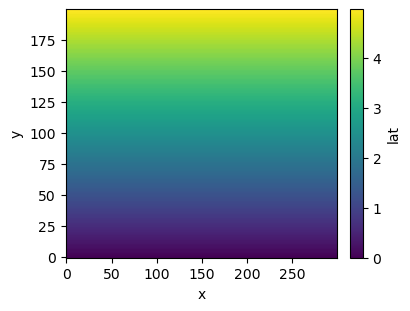

In [11]:
fig, ax = plt.subplots(figsize=(4,3), constrained_layout=True)
test_ds_HR.lat.plot(x='x', y='y')

# Selection of a region from a  global grid

In [34]:
def select_region_on_global_mesh(regional_mesh, global_mesh) :
    ds = regional_mesh
    # to take a part of the global grid corresponding to the data cut
    selection = global_mesh.lon.where((global_mesh.lon>=ds.lon.min().values) & (global_mesh.lon<=ds.lon.max().values) &\
                                  (global_mesh.lat>=ds.lat.min().values) & (global_mesh.lat<=ds.lat.max().values), drop=True)
    selected_x = list(selection.x.values)
    selected_y = list(selection.y.values)
    sel_mesh = global_mesh.isel(x=selected_x[0:-1], y=selected_y[0:-1])
    
    # reinit x and y arrays
    sel_mesh.coords['x'] = np.arange(1,len(selected_x)); sel_mesh.coords['y'] = np.arange(1,len(selected_y))
    
    return sel_mesh

Test:

In [35]:
selected_LR_test = select_region_on_global_mesh(test_ds_HR, test_ds_LR)

In [36]:
selected_LR_test

<xarray.Dataset>
Dimensions:       (y: 19, x: 29, time_counter: 10)
Coordinates:
    lon           (y, x) float64 0.0 0.25 0.5 0.75 1.0 ... 6.0 6.25 6.5 6.75 7.0
    lat           (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 4.5 4.5 4.5 4.5 4.5
  * time_counter  (time_counter) datetime64[ns] 2014-09-06 ... 2014-09-06T09:...
  * x             (x) int64 1 2 3 4 5 6 7 8 9 10 ... 21 22 23 24 25 26 27 28 29
  * y             (y) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    sosstsst      (y, x, time_counter) float64 20.0 20.0 20.0 ... 20.0 20.0 20.0
    sosaline      (y, x, time_counter) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tmask         (y, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    description:  Test dataset

# Build staggered grid (prepare for coarsening)

Rename and arrange the coordinates on a staggered grid to make dataset suitable for `xgcm` and `xESMF` packages :

`x_c`, `y_c` - axes corresponding to the centers of the grid cells</br>
`x_b`, `y_b` - axes corresponding to the right faces of the grid cells, <i>b</i> - for 'boundary'. This axis is necessary for the `xESMF` regridding procedure, in particular, latitude and longitude at the corner of the cells. To find coordinates of the corners, one can use functionaly of `xgcm` package to generate the missing grid and interpolate latitude and logitude on the cell-corner grid.

For better understanding the functionality of `xgcm` library, one can check out example on grid autogeneration https://xgcm.readthedocs.io/en/latest/xgcm-examples/05_autogenerate.htmlhttps://xgcm.readthedocs.io/en/latest/xgcm-examples/05_autogenerate.html

In [12]:
def built_dataset_with_correct_coordinates(input_ds) :
    # create am empty dataset with staggered grid and fill it with necesssary coordinates
    # It's for 2D data (no z-axis here) !
    ds = xr.Dataset({},
                   coords={"x_c": np.arange(len(input_ds['x'])),\
                           "y_c": np.arange(len(input_ds['y']))})
    if 'time_counter' in input_ds.coords :
        ds.coords['time_counter'] = input_ds['time_counter'].values
    try :
        ds.coords['lat'] = xr.DataArray(input_ds['lat'].transpose('x','y').values, dims=['x_c', 'y_c'])
        ds.coords['lon'] = xr.DataArray(input_ds['lon'].transpose('x','y').values, dims=['x_c', 'y_c'])
        if 'tmask' in input_ds.variables :
            ds.coords['mask'] = xr.DataArray(input_ds['tmask'].transpose('x','y').values, dims=['x_c', 'y_c'])
        if 'mask' in input_ds.variables :
            ds.coords['mask'] = xr.DataArray(input_ds['mask'].transpose('x','y').values, dims=['x_c', 'y_c'])
    except KeyError :
        print("Missing coordinate or variable in the given dataset:", sys.exc_info()[1])
        raise

    # Preparation of corner coordinates (called outer axis) -> it is needed for the regridder further
    ds = xgcm.autogenerate.generate_grid_ds(ds, axes_dims_dict={'X' : 'x_c', 'Y' : 'y_c'}, \
                                                axes_coords_dict={'X' : 'lon', 'Y' : 'lat'}, position=('center', 'outer'))
    # Rename the new axes as 'x_b' and 'y_b' - requirement of xESMF regridder
    ds = ds.rename({'x_c_outer': 'x_b','y_c_outer': 'y_b'})
    
    # build the grid object 
    grid = xgcm.Grid(ds, periodic=False,\
                         coords={'X' : {'center' : 'x_c', 'outer' : 'x_b'}, \
                                'Y' : {'center' : 'y_c', 'outer' : 'y_b'}})
    # interpret latitude and longitude values onto the cell corner points
    ds.coords['lon_b'] = grid.interp(da=ds['lon_outer'], axis='Y', to='outer', boundary='extend')
    ds.coords['lat_b'] = grid.interp(da=ds['lat_outer'], axis='X', to='outer', boundary='extend')  
    
    # fill with the data
    for var in list(input_ds.data_vars) :
        ds[var] = input_ds[var].\
        reindex(x = ds.x_c.values, y = ds.y_c.values, method='bfill').\
        rename(y='y_c', x='x_c')
        
    return ds, grid

Test:

In [15]:
correct_coords_test_ds_HR, grid = built_dataset_with_correct_coordinates(test_ds_HR)

In [16]:
correct_coords_test_ds_HR

<xarray.Dataset>
Dimensions:       (x_c: 300, y_c: 200, time_counter: 10, x_b: 301, y_b: 201)
Coordinates:
  * x_c           (x_c) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * y_c           (y_c) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * time_counter  (time_counter) datetime64[ns] 2014-09-06 ... 2014-09-06T09:...
    lat           (x_c, y_c) float64 0.0 0.025 0.05 0.075 ... 4.925 4.95 4.975
    lon           (x_c, y_c) float64 0.0 0.0 0.0 0.0 ... 7.475 7.475 7.475 7.475
    mask          (x_c, y_c) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
  * x_b           (x_b) float64 -0.5 0.5 1.5 2.5 3.5 ... 296.5 297.5 298.5 299.5
  * y_b           (y_b) float64 -0.5 0.5 1.5 2.5 3.5 ... 196.5 197.5 198.5 199.5
    lon_outer     (x_b, y_c) float64 -0.0125 -0.0125 -0.0125 ... 7.488 7.488
    lat_outer     (x_c, y_b) float64 -0.0125 0.0125 0.0375 ... 4.938 4.963 4.988
    lon_b         (x_b, y_b) float64 -0.0125 -0.0125 -0.0125 ... 7.488 7.488
    lat_b         (x_b, y_b) float64 -0.0125 0.0125 0.0375 ... 4.938 4.963 4.988
Data variables:
    sosstsst      (y_c, x_c, time_counter) float64 20.0 20.0 20.0 ... 20.0 20.0
    sosaline      (y_c, x_c, time_counter) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tmask         (y_c, x_c) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0

# Buld metrics

Compute dictances between grid nodes and link it to the grid object. Can be used for computation of spatial gradients or integrals, for example.

Firstly, to build the metrics, one need to have distances between the nodes of the cells. One can use information on latitude and longitude to calculate these distances:

In [19]:
def distances_from_latlon_to_meters(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        From https://xgcm.readthedocs.io/en/latest/xgcm-examples/05_autogenerate.html
        """

        distance_1deg_equator = 111300.0
        dx = dlon * np.cos(np.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

In [20]:
metrics = {
    ('X',): ['dx_c'], # X distances
    ('Y',): ['dy_c'], # Y distances
    ('X', 'Y',): ['area'] # Areas 
}

In [21]:
def built_metrics(input_ds, metrics) :
    ds = input_ds.copy()
    
    # build the grid object 
    grid = xgcm.Grid(ds, periodic=False,\
                         coords={'X' : {'center' : 'x_c', 'outer' : 'x_b'}, \
                                'Y' : {'center' : 'y_c', 'outer' : 'y_b'}})
    
    # convert dictances between grid points from lat/lon in meters
    dlonc = grid.diff(ds.lon_outer, 'X', boundary='fill', fill_value=np.nan)
    dlatc = grid.diff(ds.lat_outer, 'Y', boundary='fill', fill_value=np.nan)
    ds.coords['dx_c'], ds.coords['dy_c'] = distances_from_latlon_to_meters(dlonc, dlatc, ds.lon, ds.lat)
    
    # compute area of cells
    ds.coords['area'] = ds.coords['dx_c']*ds.coords['dy_c']
    
    # rebuild the grid object with metrics
    grid = xgcm.Grid(ds, periodic=False, metrics=metrics,\
                     coords={'X' : {'center' : 'x_c', 'outer' : 'x_b'}, \
                            'Y' : {'center' : 'y_c', 'outer' : 'y_b'}}) 
    return ds, grid

Test:

In [24]:
correct_coords_test_ds_HR_with_metrics, grid_with_metrics = built_metrics(correct_coords_test_ds_HR, metrics)

In [25]:
correct_coords_test_ds_HR_with_metrics

<xarray.Dataset>
Dimensions:       (x_c: 300, y_c: 200, time_counter: 10, x_b: 301, y_b: 201)
Coordinates: (12/15)
  * x_c           (x_c) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
  * y_c           (y_c) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * time_counter  (time_counter) datetime64[ns] 2014-09-06 ... 2014-09-06T09:...
    lat           (x_c, y_c) float64 0.0 0.025 0.05 0.075 ... 4.925 4.95 4.975
    lon           (x_c, y_c) float64 0.0 0.0 0.0 0.0 ... 7.475 7.475 7.475 7.475
    mask          (x_c, y_c) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    ...            ...
    lat_outer     (x_c, y_b) float64 -0.0125 0.0125 0.0375 ... 4.938 4.963 4.988
    lon_b         (x_b, y_b) float64 -0.0125 -0.0125 -0.0125 ... 7.488 7.488
    lat_b         (x_b, y_b) float64 -0.0125 0.0125 0.0375 ... 4.938 4.963 4.988
    dx_c          (x_c, y_c) float64 2.782e+03 2.782e+03 ... 2.772e+03 2.772e+03
    dy_c          (x_c, y_c) float64 2.782e+03 2.783e+03 ... 2.783e+03 2.783e+03
    area          (x_c, y_c) float64 7.742e+06 7.742e+06 ... 7.713e+06 7.713e+06
Data variables:
    sosstsst      (y_c, x_c, time_counter) float64 20.0 20.0 20.0 ... 20.0 20.0
    sosaline      (y_c, x_c, time_counter) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tmask         (y_c, x_c) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0

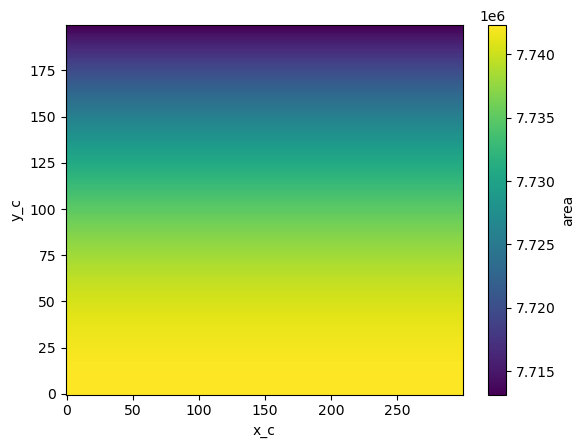

In [26]:
correct_coords_test_ds_HR_with_metrics.area.plot(x='x_c', y='y_c')

# Computation of variables before coarsening

The variables that need to be computed before the coarsening are the square values of temperature and salinity, as well as the density anomaly $\sigma_0$. 

In [27]:
g = 9.80665 
rho_0 = 1023.6

In [28]:
def vars_before_coars(input_ds, grid) :
    ds = input_ds
    
    # Compute density
    ds['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, ds.sosaline, ds.sosstsst, dask='parallelized')
    
    # Squares for computing the subgrid variance
    ds['sigma0_true_sqr'] = ds['sigma0_true']**2
    ds['sosstsst_sqr'] = ds['sosstsst']**2
    ds['sosaline_sqr'] = ds['sosaline']**2
    return ds

In [30]:
correct_coords_test_ds_HR = vars_before_coars(correct_coords_test_ds_HR, grid)

# Computation of variables after coarsening

In [67]:
def vars_after_coars(input_ds, grid) :
    ds = input_ds
    
    # compute sigma_0 density with coarsened temp and salinity
    ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds.sosaline, ds.sosstsst, dask='parallelized')
    
    # density error - difference between the density evaluated on HR temp and salinity and coarsened 
    # with the density evaluated with coarsened fields of temp and salinity.
    # This difference represents the subgrid density error.
    ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']  
    
    # subgrid variance of temperature and salinity
    for var in ['sosstsst', 'sosaline'] :
        ds[var+'_var'] = ds[var+'_sqr'] - ds[var]**2
        
    temp_pressure = xr.zeros_like(ds.sosstsst)
        
    # first derivatives of EOS
    ds['alpha'] = xr.apply_ufunc(gsw.density.alpha, ds.sosaline, ds.sosstsst, temp_pressure, dask='parallelized')
    ds['beta'] = xr.apply_ufunc(gsw.density.beta, ds.sosaline, ds.sosstsst, temp_pressure, dask='parallelized')
    
    # second derivatives of EOS
    # needed this trick because gsw package does not have full support of dask yet
    temp_array = xr.apply_ufunc(gsw.rho_second_derivatives, ds.sosaline, ds.sosstsst, temp_pressure, \
                            input_core_dims = [('time_counter', 'y_c', 'x_c') for i in range(3)],\
                           output_core_dims = [('time_counter', 'y_c', 'x_c') for i in range(5)],\
                           dask='parallelized', dask_gufunc_kwargs=dict({'allow_rechunk' : True})) 
    ds['rho_sa_sa'] = xr.DataArray(temp_array[0], dims=['time_counter', 'y_c', 'x_c'])
    ds['rho_sa_ct'] = xr.DataArray(temp_array[1], dims=['time_counter', 'y_c', 'x_c'])
    ds['rho_ct_ct'] = xr.DataArray(temp_array[2], dims=['time_counter', 'y_c', 'x_c'])
    ds['rho_sa_p'] = xr.DataArray(temp_array[3], dims=['time_counter', 'y_c', 'x_c'])
    ds['rho_ct_p'] = xr.DataArray(temp_array[4], dims=['time_counter', 'y_c', 'x_c'])
    del temp_array, temp_pressure
    
    # horizontal differences
    for variable in ['sosstsst', 'sosaline', 'sigma0_model', 'sigma0_delta', 'sosstsst_var', 'sosaline_var'] :
        for axis in ['X', 'Y'] :
            ds['diff_'+axis+'_'+variable] = grid.diff(ds[variable], axis=axis, boundary='extend')
        ds['diff_'+variable+'_sqr'] = grid.interp(ds['diff_X_'+variable]**2, 'X') + \
                                   grid.interp(ds['diff_Y_'+variable]**2, 'Y')    
        
    # predictors for deterministic parametrization
    ds['predictor_T'] = 0.5*ds['rho_ct_ct']*ds['diff_sosstsst_sqr']
    ds['predictor_S'] = 0.5*ds['rho_sa_sa']*ds['diff_sosaline_sqr']
    ds['predictor_TS'] = 0.5*ds['rho_sa_ct']*np.sqrt(ds['diff_sosaline_sqr']*ds['diff_sosstsst_sqr'])
    
    return ds

Test:

In [32]:
new_ds_HR_test = vars_after_coars(correct_coords_test_ds_HR, grid )

# Coasening function

In [38]:
def corsen_non_uniform_grid(input_ds_HR, input_mesh_LR) :
    # prepare coordinates for the regridder
    ds_HR = input_ds_HR.drop_vars(['lon_outer', 'lat_outer', 'dx_c', 'dy_c'], errors='ignore').\
    rename({'x_c' : 'x', 'y_c' : 'y'})   
    
    ds_LR = input_mesh_LR.drop_vars(['lon_outer', 'lat_outer', 'dx_c', 'dy_c'], errors='ignore').\
    rename({'x_c' : 'x', 'y_c' : 'y'})    
    
    # create regridder, i.e. compute weights for coarsening
    # use "conservative_normed" method that is valid for non-unoform grids
    # by weightning the coarsening coefficients by the cell area
    # and takes into account mask (since data contains nans)
    regridder = xe.Regridder(ds_HR, ds_LR, method="conservative_normed")
    
    # perform coasening (should be dask friendly in theory)
    ds_coarsen = regridder(ds_HR)
    
    # cleanup a bit
    ds_coarsen = ds_coarsen.drop_dims(['x_b', 'y_b']).rename({'x' : 'x_c', 'y' : 'y_c'})
    
    # reapply the mask
    ds_coarsen = xr.where(ds_coarsen.mask>0, ds_coarsen, np.nan)

    return ds_coarsen

Test:

In [42]:
selected_LR_test = select_region_on_global_mesh(test_ds_HR, test_ds_LR)

In [43]:
correct_coords_selected_LR_test, grid = built_dataset_with_correct_coordinates(selected_LR_test)

In [44]:
test_coarsen = corsen_non_uniform_grid(correct_coords_test_ds_HR, correct_coords_selected_LR_test)

/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [45]:
test_coarsen

<xarray.Dataset>
Dimensions:                (x_c: 29, y_c: 19, time_counter: 10)
Coordinates:
  * x_c                    (x_c) int64 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28
  * y_c                    (y_c) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18
    lon                    (x_c, y_c) float64 0.0 0.0 0.0 0.0 ... 7.0 7.0 7.0
    mask                   (x_c, y_c) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    lat                    (x_c, y_c) float64 0.0 0.25 0.5 0.75 ... 4.0 4.25 4.5
  * time_counter           (time_counter) datetime64[ns] 2014-09-06 ... 2014-...
Data variables: (12/27)
    sosstsst               (x_c, y_c, time_counter) float64 20.0 20.0 ... 20.0
    sosaline               (x_c, y_c, time_counter) float64 0.0 0.0 ... 0.0 0.0
    tmask                  (x_c, y_c) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    sigma0_true            (x_c, y_c, time_counter) float64 -1.592 ... -1.592
    sigma0_true_sqr        (x_c, y_c, time_counter) float64 2.534 ... 2.534
    sosstsst_sqr           (x_c, y_c, time_counter) float64 400.0 ... 400.0
    ...                     ...
    diff_sigma0_delta_sqr  (x_c, y_c, time_counter) float64 0.0 0.0 ... 0.0 0.0
    diff_sosstsst_var_sqr  (x_c, y_c, time_counter) float64 0.0 0.0 ... 0.0 0.0
    diff_sosaline_var_sqr  (x_c, y_c, time_counter) float64 0.0 0.0 ... 0.0 0.0
    predictor_T            (x_c, y_c, time_counter) float64 0.0 0.0 ... 0.0 0.0
    predictor_S            (x_c, y_c, time_counter) float64 0.0 0.0 ... 0.0 0.0
    predictor_TS           (x_c, y_c, time_counter) float64 0.0 0.0 ... 0.0 0.0

In [46]:
print(test_coarsen.sosstsst.min().values)
print(test_coarsen.sosstsst.max().values)

19.99999999999998
20.00000000000002


# Read data

## HR data - eNATL60

Import Pangeo catalog parameters:

In [55]:
from validate_catalog import all_params
params_dict, cat = all_params()

Create data structure in a form of a list of dictionaries. Each dictionary entity correcponds to a `xArray` dataset from the Pangeo catalog.

In [56]:
data=[dict() for i in range(6)]

In [57]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

Adjust slicing (if needed):

In [58]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)
time_slice = slice(0,-1,None)

data_slice = dict(time_counter=time_slice,y=y_slice,x=x_slice) 

In [59]:
chunking_dict = 'default'

Read and prepare the datasets. Note that it is dask 'lazy' opening of `.zarr` files, i.e. the files are not loaded entirely to the memory. If there is enough memory then `.load` can be added at the end of this subroutine, in this case the data will be loaded to the memory and processing will go way faster. If there is not enough memory, the data will be trated in portions with `Dask` functionality.

In [57]:
%%time
for i, data_dict in enumerate(data) :
    #current_set = xr.open_dataset('/Users/ana/data/eNATL60_extractions/region'+str(data_dict['region'])+'_'+data_dict['season']+'.nc')
    
    # load data from pangeo cloud
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask()

    # slice if needed
    current_set = current_set.isel(data_slice)
    
    # resample by averaging over a given time period (if needed) - example of time averaging over 1 day 
    #current_set = current_set.resample({'time_counter' : '1D'}, closed='right', label='right').mean()
    
    # chunk for optimization of dask computations
    if (chunking_dict == 'default') :
        nb_of_dask_workers = len(client.scheduler_info()['workers'])
        # default chunkig along the time axis
        time_chunks = len(current_set.time_counter)//nb_of_dask_workers
        current_set = current_set.chunk({'x' : -1, 'y' : -1, 'time_counter' : time_chunks})
    else : 
        current_set = current_set.chunk(chunking_dict)
        
    # load data to the memory (if data is not big and there is anough memory available)
    current_set = current_set.load()
        
    data[i]['HR'] = current_set

CPU times: user 3.03 s, sys: 2.2 s, total: 5.23 s
Wall time: 2min 44s


Just to check what is inside the file:

In [58]:
data[0]['HR']

<xarray.Dataset>
Dimensions:        (y: 762, x: 610, time_counter: 43)
Coordinates: (12/15)
    depth          (y, x) float32 819.0 813.6 813.6 ... 2.413e+03 2.434e+03
    e1f            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1t            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1u            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1v            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e2f            (y, x) float64 1.564e+03 1.564e+03 ... 1.332e+03 1.332e+03
    ...             ...
    lat            (y, x) float32 30.0 30.0 30.0 30.0 ... 39.98 39.98 39.98
    lon            (y, x) float32 -78.01 -77.99 -77.97 ... -68.05 -68.04 -68.02
    nav_lat        (y, x) float32 30.0 30.0 30.0 30.0 ... 39.98 39.98 39.98
    nav_lon        (y, x) float32 -78.01 -77.99 -77.97 ... -68.05 -68.04 -68.02
    time_centered  (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask          (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    qt_oce         (time_counter, y, x) float32 -420.2 -421.5 ... -348.7 -346.8
    somecrty       (time_counter, y, x) float32 0.5727 0.5736 ... -0.2155
    sometauy       (time_counter, y, x) float32 -0.05811 -0.0582 ... -0.05383
    sosaline       (time_counter, y, x) float32 36.53 36.53 ... 36.36 36.36
    sossheig       (time_counter, y, x) float32 0.6283 0.6361 ... 0.113 0.1117
    ...             ...
    sowaflup       (time_counter, y, x) float32 0.0001035 ... 0.0001291
    sozocrtx       (time_counter, y, x) float32 0.3234 0.3071 ... 0.6409 0.643
    sozotaux       (time_counter, y, x) float32 -0.05867 -0.05846 ... 0.2439
    tmask          (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    umask          (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    vmask          (y, x) int8 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1

In [59]:
print(data[0]['HR'].nbytes / 1e9, "GiB")

0.760446208 GiB


## LR Grid - eORCA025

In [60]:
global_grid_LR = xr.open_dataset('../../global_eORCA025_mesh.nc', chunks='auto')
global_grid_LR.coords['area'] = global_grid_LR['e1t']*global_grid_LR['e2t']

In [61]:
global_grid_LR

<xarray.Dataset>
Dimensions:  (y: 1205, y_r: 1205, x: 1440, x_r: 1440, x_b: 1441, y_b: 1206)
Coordinates: (12/29)
  * y        (y) int64 1 2 3 4 5 6 7 8 ... 1199 1200 1201 1202 1203 1204 1205
  * y_r      (y_r) float64 1.5 2.5 3.5 4.5 ... 1.204e+03 1.204e+03 1.206e+03
  * x        (x) int64 1 2 3 4 5 6 7 8 ... 1434 1435 1436 1437 1438 1439 1440
  * x_r      (x_r) float64 1.5 2.5 3.5 4.5 ... 1.438e+03 1.44e+03 1.44e+03
    lat      (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    llat_cr  (y, x_r) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    ...       ...
    fmask    (y_r, x_r) int8 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * x_b      (x_b) float64 0.5 1.5 2.5 3.5 ... 1.438e+03 1.44e+03 1.44e+03
  * y_b      (y_b) float64 0.5 1.5 2.5 3.5 ... 1.204e+03 1.204e+03 1.206e+03
    lon_b    (y_b, x_b) float64 dask.array<chunksize=(1206, 1441), meta=np.ndarray>
    lat_b    (y_b, x_b) float64 dask.array<chunksize=(1206, 1441), meta=np.ndarray>
    area     (y, x) float64 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Data variables:
    *empty*

# Run the coarsening for all eNATL60 datasets

Get the persistent bucket environment variable on the 2i2c cloud:

In [62]:
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET'] 

Path to the folder where to write coarsened fields. The coarseed files will be stored on cloud in this persistent bucket, to be reused after.

In [63]:
output_path = PERSISTENT_BUCKET

In [64]:
%%time
for i, data_entity in enumerate(data) :  # loop over all HR datasets
    # select the region on the global LR mesh corresponding to HR data
    sel_LR_mesh = select_region_on_global_mesh(data_entity['HR'], global_grid_LR)
    
    # built the coordinates
    ds_HR, grid_HR = built_dataset_with_correct_coordinates(data_entity['HR'])
    ds_LR, grid_LR = built_dataset_with_correct_coordinates(sel_LR_mesh)
    
    # compute variables on HR mesh before coarsening
    ds_HR = vars_before_coars(ds_HR, grid_HR)

    # coarsen HE data
    ds_HR_coarsen = corsen_non_uniform_grid(ds_HR, ds_LR)

    # compute variables on the LR grid after coarsening
    ds_HR_coarsen = vars_after_coars(ds_HR_coarsen, grid_LR)
    data_entity['LR'] = ds_HR_coarsen
    
    # save the coarsened 
    data_entity['LR'].to_zarr(store=f'{output_path}/data'+str(i)+'.zarr', mode='w')  # write data
    print('Finished writing dataset '+str(i))

/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Finished writing dataset 0


/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Finished writing dataset 1


/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Finished writing dataset 2


/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Finished writing dataset 3


/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Finished writing dataset 4


/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')
/srv/conda/envs/notebook/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


Finished writing dataset 5
CPU times: user 1min 32s, sys: 4.55 s, total: 1min 37s
Wall time: 6min 38s


In [65]:
data[0]['LR']

<xarray.Dataset>
Dimensions:                (x_c: 41, y_c: 51, time_counter: 43, x_b: 42, y_b: 52)
Coordinates:
  * x_c                    (x_c) int64 0 1 2 3 4 5 6 7 ... 34 35 36 37 38 39 40
  * y_c                    (y_c) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
    lon                    (x_c, y_c) float64 -77.76 -77.76 ... -67.92 -67.93
    mask                   (x_c, y_c) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    lat                    (x_c, y_c) float64 30.36 30.57 30.78 ... 39.98 40.16
  * time_counter           (time_counter) datetime64[ns] 2010-02-01T00:30:00 ...
    time_centered          (time_counter) datetime64[ns] 2010-02-01T00:30:00 ...
  * x_b                    (x_b) float64 -0.5 0.5 1.5 2.5 ... 38.5 39.5 40.5
  * y_b                    (y_b) float64 -0.5 0.5 1.5 2.5 ... 48.5 49.5 50.5
Data variables: (12/49)
    fmask                  (x_c, y_c) float64 0.0 1.0 0.0 1.0 ... 1.0 1.0 0.0
    qt_oce                 (x_c, y_c, time_counter) float32 -428.5 ... nan
    somecrty               (x_c, y_c, time_counter) float32 0.4513 ... nan
    sometauy               (x_c, y_c, time_counter) float32 -0.05782 ... nan
    sosaline               (x_c, y_c, time_counter) float32 36.51 36.5 ... nan
    sossheig               (x_c, y_c, time_counter) float32 0.6431 ... nan
    ...                     ...
    diff_X_sosaline_var    (x_b, y_c, time_counter) float32 0.0 0.0 ... nan nan
    diff_Y_sosaline_var    (x_c, y_b, time_counter) float32 0.0 0.0 ... nan nan
    diff_sosaline_var_sqr  (x_c, y_c, time_counter) float32 7.451e-09 ... nan
    predictor_T            (time_counter, y_c, x_c) float64 -0.000119 ... nan
    predictor_S            (time_counter, y_c, x_c) float64 1.397e-08 ... nan
    predictor_TS           (time_counter, y_c, x_c) float64 -2.096e-06 ... nan

Check the volume of the coarsened data:

In [66]:
print(data[0]['LR'].nbytes / 1e6, "MiB")

23.608607 MiB


# Plots

CPU times: user 1.2 s, sys: 119 ms, total: 1.32 s
Wall time: 21.6 s


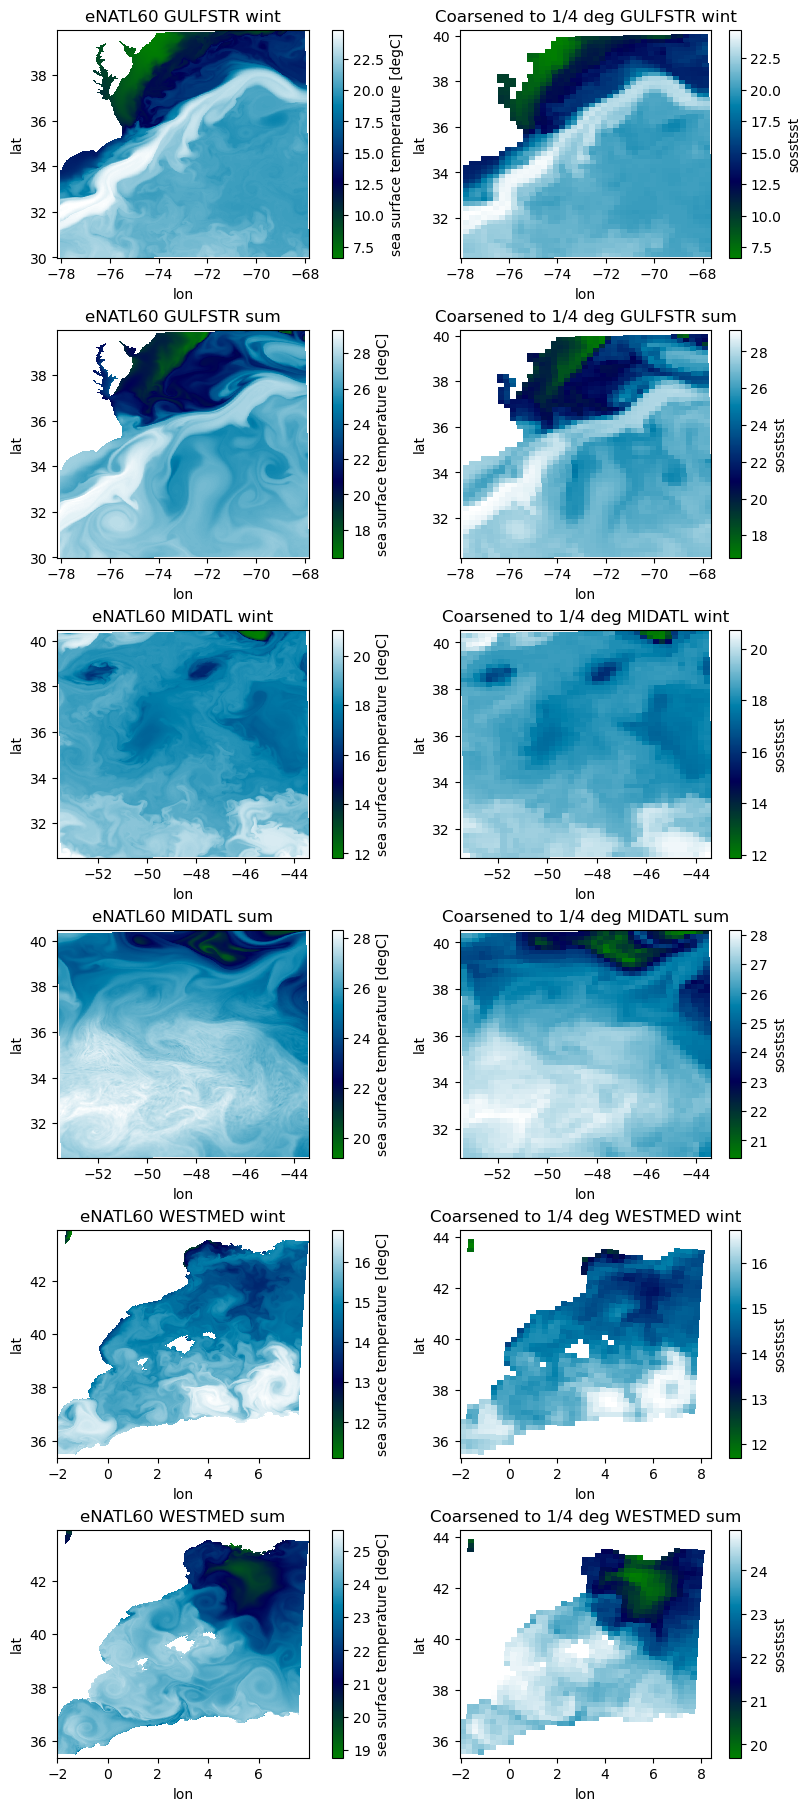

In [56]:
%%time
fig, ax = plt.subplots(ncols=2, nrows=len(data), figsize=(8,3.0*len(data)), constrained_layout=True)
for row, data_entity in enumerate(data) :
    data_entity['HR'].sosstsst.isel(time_counter=0).plot(ax=ax[row,0], x='lon', y='lat',cmap='ocean')
    data_entity['LR'].sosstsst.isel(time_counter=0).plot(ax=ax[row,1], x='lon', y='lat',cmap='ocean')
    ax[row,0].set(title='eNATL60 '+data_entity['label'])
    ax[row,1].set(title='Coarsened to 1/4 deg '+data_entity['label'])